# Benchmark

This notebook compares compute costs of UMAP (=$k$-NN), the exact $k$-MST (=KDTree-based boruvka) and approximate $k$-MST (=NNDescent-based boruvka) algorithms. The dataset samples and generated graphs are stored for re-analysis and visualisation. On MNIST, the approximate $k$-MST is roughly two orders of magnitude faster than the exact $k$-MST algorithm!

In [1]:
import time
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.sparse import save_npz

from sklearn.datasets import fetch_openml
from sklearn.utils.random import sample_without_replacement

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from umap import UMAP
from multi_mst import KMST, KMSTDescent

In [2]:
# Trigger numba compilation
_ = KMSTDescent(umap_kwargs=dict(transform_mode="graph")).fit(np.random.rand(100, 2))
_ = KMST(umap_kwargs=dict(transform_mode="graph")).fit(np.random.rand(100, 2))
_ = UMAP(force_approximation_algorithm=True, transform_mode="graph").fit_transform(
    np.random.rand(100, 2)
)

## Timed algorithms

Implement parameter sweep, output logging, and timing code.

In [3]:
def time_task(task, *args, **kwargs):
    """Outputs compute time in seconds."""
    start_time = time.perf_counter()
    task(*args, **kwargs)
    end_time = time.perf_counter()
    return end_time - start_time


In [4]:
def run_dmst(data, n_neighbors):
    mst = KMSTDescent(
        num_neighbors=n_neighbors,
        umap_kwargs=dict(transform_mode="graph"),
    )
    compute_time = time_task(lambda: mst.fit(data))
    return compute_time, mst.graph_


def run_kmst(data, n_neighbors):
    mst = KMST(
        num_neighbors=n_neighbors,
        umap_kwargs=dict(transform_mode="graph"),
    )
    compute_time = time_task(lambda: mst.fit(data))
    return compute_time, mst.graph_


def run_umap(data, n_neighbors):
    umap = UMAP(
        n_neighbors=n_neighbors,
        transform_mode="graph",
    )
    compute_time = time_task(lambda: umap.fit(data))
    return compute_time, umap.graph_


mains = {"dmst": run_dmst, "kmst": run_kmst, "umap": run_umap}


def run(data, algorithm, n_neighbors):
    return mains[algorithm](data, n_neighbors)

In [5]:
def compute_and_evaluate_setting(
    data,
    algorithm="dmst",
    repeat=0,
    frac=1.0,
    n_neighbors=5,
):
    compute_time, graph = run(data, algorithm, n_neighbors)
    save_npz(
        f"./data/generated/mnist/graph_{algorithm}_{n_neighbors}_{frac}_{repeat}.npz",
        graph.tocoo(),
    )
    return (
        algorithm,
        frac,
        n_neighbors,
        repeat,
        graph.nnz,
        compute_time,
    )

In [6]:
def init_file(path):
    handle = open(path, "w", buffering=1)
    handle.write(
        "algorithm,sample_fraction,n_neighbors,repeat,num_edges,compute_time\n"
    )
    return handle


def write_line(handle, *args):
    handle.write(",".join([str(v) for v in args]) + "\n")

In [2]:
repeats = 5
algorithms = ['dmst', 'umap', 'kmst']
fraction = np.exp(np.linspace(np.log(0.1), np.log(1), 5)).round(2)
n_neighbors = [2, 3, 6]

total = len(algorithms) * len(fraction) * len(n_neighbors)

In [4]:
fraction * 70000

array([ 7000., 12600., 22400., 39200., 70000.])

In [3]:
df, target = fetch_openml("mnist_784", version=1, return_X_y=True)
df.shape

(70000, 784)

In [9]:
output = init_file("./data/generated/mnist/metrics.csv")
for repeat in tqdm(range(repeats)):
    pbar = tqdm(desc="Compute", total=total, leave=False)
    for frac in fraction:
        sample_idx = sample_without_replacement(df.shape[0], int(df.shape[0] * frac))
        np.save(f"./data/generated/mnist/sampled_indices_{frac}_{repeat}.npy", sample_idx)
        X = df.iloc[sample_idx, :]
        for algorithm in algorithms:
            for k in n_neighbors:
                result = compute_and_evaluate_setting(X, algorithm, repeat, frac, k)
                write_line(output, *result)
                pbar.update()
    pbar.close()
output.close()

100%|██████████| 5/5 [4:48:29<00:00, 3461.80s/it]  


## Results

NNDescent-based $k$-MST is more expensive that NNDescent based $k$-NN. Scaling appears a bit steeper but still usable. Definately a lot quicker than KDTree-based MSTs!

In [13]:
import seaborn as sns
import matplotlib.lines as ml
from lib.plotting import *

configure_matplotlib()

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
values = pd.read_csv("./data/generated/mnist/metrics.csv")

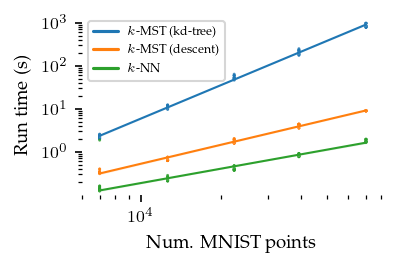

In [20]:
from matplotlib.ticker import FixedLocator

# Fit robust linear regression in log-log space
fig = sized_fig(1/2)
ax = plt.gca()
for i, alg in enumerate(["kmst", "dmst", "umap"]):
    alg_values = values[values["algorithm"] == alg]
    sns.regplot(
        x=np.log10(alg_values["sample_fraction"] * df.shape[0]),
        y=np.log10(alg_values["compute_time"]),
        ci=95,
        order=1,
        robust=True,
        color=f"C{i}",
        units=alg_values["repeat"],
        scatter_kws={"edgecolor": "none", "linewidths": 0, "s": 2},
        line_kws={"linewidth": 1},
        ax=ax,
    )
ax.set_xlabel("Num. MNIST points")
ax.set_ylabel("Run time (s)")

# Draw log y-ticks
y_ticks = np.array([0.0, 1.0, 2.0, 3.0])
plt.ylim(-1, plt.ylim()[1])
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(lambda x, pos: f"$10^{{{int(x)}}}$")
ax.get_yaxis().set_minor_locator(
    FixedLocator(locs=np.concat((
        np.log10(np.arange(0.2, 1, 0.1) * 10.0 ** y_ticks[0]),
        np.log10(np.arange(2, 10) * 10.0 ** y_ticks[None].T).ravel())
    ))
)

# Draw log x-ticks
x_ticks = np.array([4.0])
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(lambda x, pos: f"$10^{{{int(x)}}}$")
ax.get_xaxis().set_minor_locator(
    FixedLocator(locs=np.log10(np.array(
        [0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 30, 40, 50, 60, 70, 80]
    ) * 10.0 ** x_ticks[None].T).ravel())
)
plt.xlim(np.log10([6000, 80000]))

# Legend
adjust_legend_subtitles(
    plt.legend(
        loc="upper left",
        handles=[
            ml.Line2D([], [], color=f"C{j}", label=f"{v}")
            for j, v in enumerate(['$k$-MST (kd-tree)', '$k$-MST (descent)', '$k$-NN'])
        ]
    )
)
plt.subplots_adjust(left=0.17, right=0.9, top=0.95, bottom=0.24)
plt.savefig("./images/mnist_scaling.pdf", pad_inches=0)
plt.show()